In [1]:
class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = np.empty((len(self.layer_sizes) - 1,), dtype=object)
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] = np.random.uniform(-1, 1, size=[self.layer_sizes[i], self.layer_sizes[i+1]])

    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | test_loss = {val_loss.round(3)} | test_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_data(dir_name):
    data = list() # init a list called `data`
    
    with open(dir_name,"r") as f: # open the directory as a read ("r"), call it `f`
        for line in f: # iterate through each `line` in `f`
            split_line = np.array(line.split(',')) # split lines by `,` - cast the resultant list into an numpy array
            split_line = split_line.astype(np.float32) # make the numpy array of str into floats
            data.append(split_line) # collect the sample into the `data` list
            
    data = np.asarray(data) # convert the `data` list into a numpy array for easier indexing
    
    # as the first number in each sample is the label (0-9), extract that from the rest and return both (X,Y)
    return data[:,1:],data[:,0]

In [4]:
X_train,Y_train = load_data(r"dataset\mnist_test.csv")
X_test,Y_test = load_data(r"dataset\mnist_test.csv")

In [5]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 10000 x 784
The shape of the test set is: 10000 x 784


In [6]:
index = 0
Y_train[index], X_train[index]

(7.0,
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 

In [7]:
# rescale data between 0 - 1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train (y_train) and test (y_test) set labels
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size), Y_train.astype(int)] = 1.0
y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size), Y_test.astype(int)] = 1.0


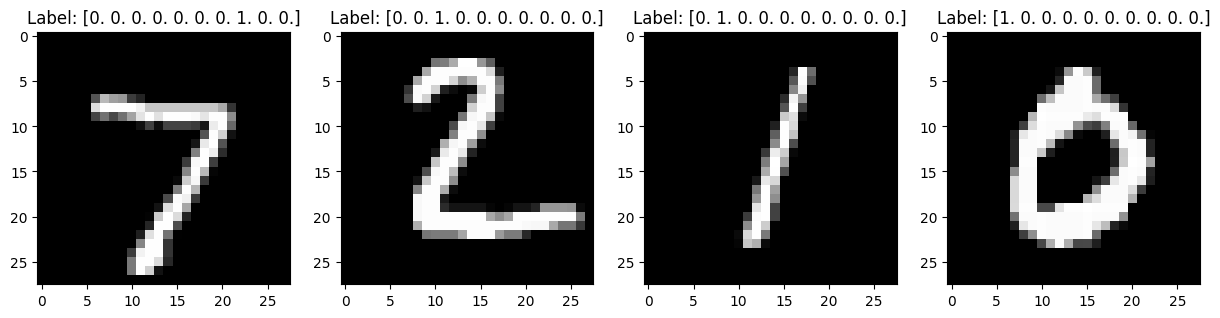

In [8]:
num_images = 4
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    ax.set_title(f"Label: {label}")

In [9]:
model = MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=128)
model.train(batch_size=8,epochs=25,lr=1.0)

Epoch 1: loss = 1.813 | acc = 0.646 | test_loss = 1.733 | test_acc = 0.719 | train_time = 3.509 | tot_time = 3.612
Epoch 2: loss = 1.693 | acc = 0.766 | test_loss = 1.633 | test_acc = 0.828 | train_time = 1.943 | tot_time = 2.078
Epoch 3: loss = 1.627 | acc = 0.831 | test_loss = 1.612 | test_acc = 0.846 | train_time = 2.071 | tot_time = 2.155
Epoch 4: loss = 1.612 | acc = 0.845 | test_loss = 1.604 | test_acc = 0.851 | train_time = 1.747 | tot_time = 1.831
Epoch 5: loss = 1.602 | acc = 0.852 | test_loss = 1.594 | test_acc = 0.859 | train_time = 1.5 | tot_time = 1.586
Epoch 6: loss = 1.596 | acc = 0.857 | test_loss = 1.589 | test_acc = 0.863 | train_time = 1.592 | tot_time = 1.693
Epoch 7: loss = 1.59 | acc = 0.863 | test_loss = 1.585 | test_acc = 0.865 | train_time = 1.476 | tot_time = 1.563
Epoch 8: loss = 1.586 | acc = 0.865 | test_loss = 1.581 | test_acc = 0.869 | train_time = 1.44 | tot_time = 1.53
Epoch 9: loss = 1.582 | acc = 0.867 | test_loss = 1.579 | test_acc = 0.871 | train_ti

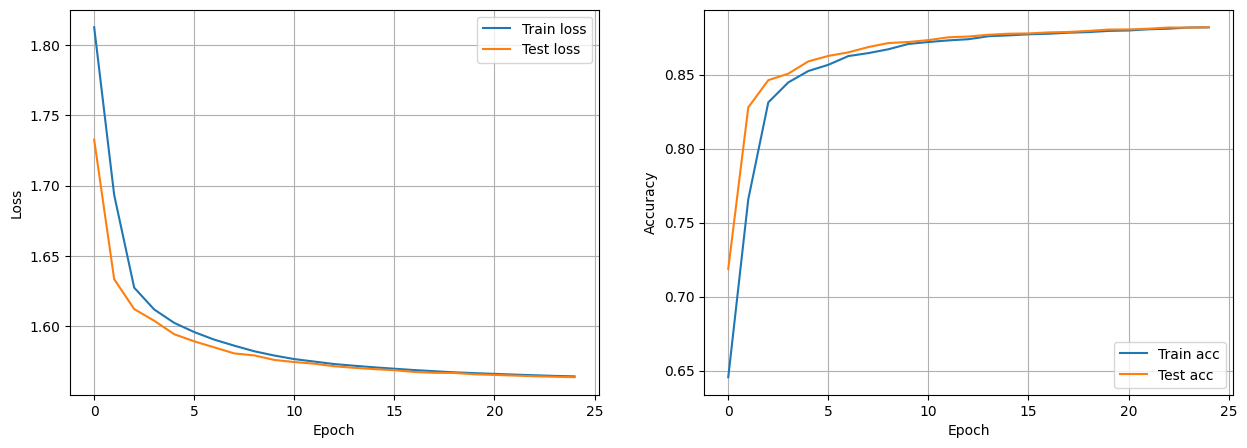

In [10]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Test loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Test acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

Epoch 1: loss = 1.736 | acc = 0.726 | test_loss = 1.596 | test_acc = 0.886 | train_time = 0.943 | tot_time = 1.019
Epoch 2: loss = 1.582 | acc = 0.896 | test_loss = 1.558 | test_acc = 0.915 | train_time = 1.109 | tot_time = 1.17
Epoch 3: loss = 1.554 | acc = 0.917 | test_loss = 1.54 | test_acc = 0.928 | train_time = 1.021 | tot_time = 1.085
Epoch 4: loss = 1.539 | acc = 0.929 | test_loss = 1.529 | test_acc = 0.935 | train_time = 1.044 | tot_time = 1.104
Epoch 5: loss = 1.53 | acc = 0.937 | test_loss = 1.522 | test_acc = 0.943 | train_time = 1.136 | tot_time = 1.198
Epoch 6: loss = 1.522 | acc = 0.942 | test_loss = 1.515 | test_acc = 0.949 | train_time = 1.066 | tot_time = 1.127
Epoch 7: loss = 1.517 | acc = 0.948 | test_loss = 1.51 | test_acc = 0.953 | train_time = 1.129 | tot_time = 1.188
Epoch 8: loss = 1.512 | acc = 0.951 | test_loss = 1.507 | test_acc = 0.956 | train_time = 1.101 | tot_time = 1.161
Epoch 9: loss = 1.508 | acc = 0.956 | test_loss = 1.503 | test_acc = 0.959 | train_t

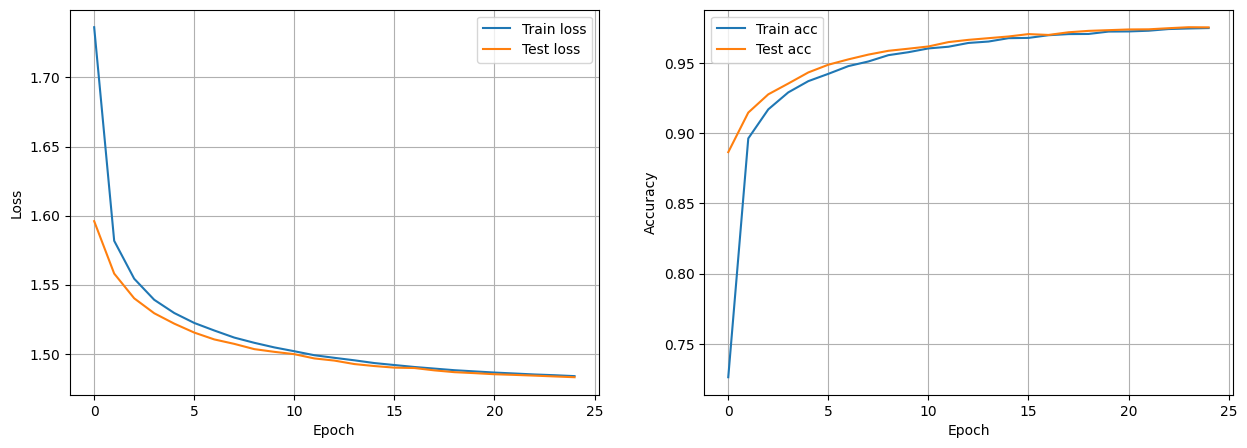

In [11]:
model = MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=64)
model.train(batch_size=8,epochs=25,lr=1.0)
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Test loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Test acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

Epoch 1: loss = 2.255 | acc = 0.097 | test_loss = 2.154 | test_acc = 0.097 | train_time = 12.201 | tot_time = 13.001
Epoch 2: loss = 2.112 | acc = 0.097 | test_loss = 2.066 | test_acc = 0.097 | train_time = 18.012 | tot_time = 19.152
Epoch 3: loss = 2.005 | acc = 0.097 | test_loss = 1.949 | test_acc = 0.097 | train_time = 22.154 | tot_time = 24.255
Epoch 4: loss = 1.874 | acc = 0.097 | test_loss = 1.827 | test_acc = 0.097 | train_time = 23.06 | tot_time = 24.624
Epoch 5: loss = 1.814 | acc = 0.097 | test_loss = 1.793 | test_acc = 0.097 | train_time = 20.599 | tot_time = 21.881
Epoch 6: loss = 1.786 | acc = 0.097 | test_loss = 1.77 | test_acc = 0.097 | train_time = 20.669 | tot_time = 22.176
Epoch 7: loss = 1.766 | acc = 0.097 | test_loss = 1.753 | test_acc = 0.097 | train_time = 20.506 | tot_time = 21.778
Epoch 8: loss = 1.75 | acc = 0.097 | test_loss = 1.739 | test_acc = 0.097 | train_time = 19.142 | tot_time = 20.396
Epoch 9: loss = 1.738 | acc = 0.097 | test_loss = 1.729 | test_acc 

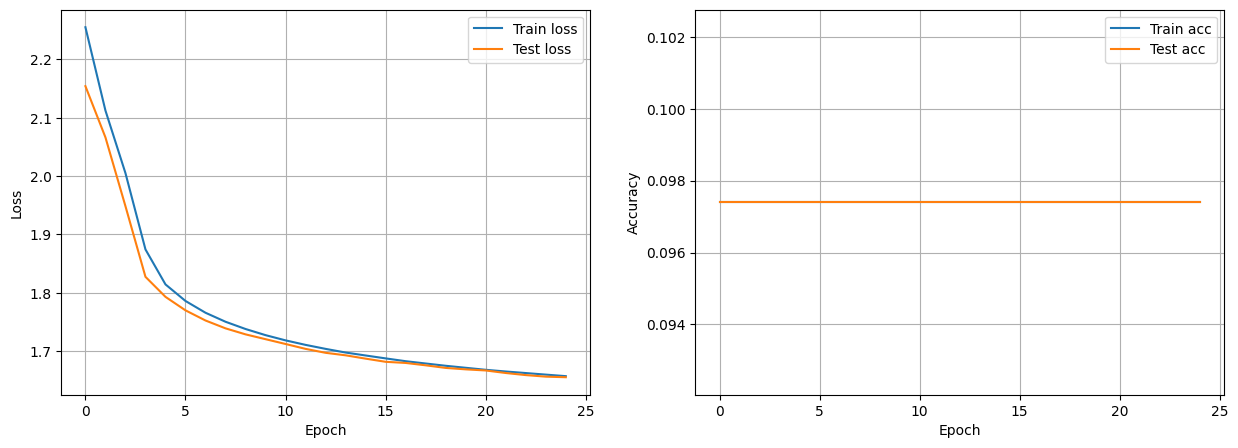

In [12]:
model = MLP(X_train,Y_train,X_test,Y_test,L=10,N_l=256)
model.train(batch_size=8,epochs=25,lr=0.01)
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Test loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Test acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()